### Using Tree data

In [1]:
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import gaussian_process

dendro = pd.read_feather("data/17766_12_D.feather")
dendro

,dendroNr,DOY,hour,species,growth
0,HA_001_2012,0,0.0,Beech,0.000
1,HA_001_2012,1,0.5,Beech,0.000
2,HA_001_2012,2,1.0,Beech,0.000
3,HA_001_2012,3,1.5,Beech,0.000
4,HA_001_2012,4,2.0,Beech,0.000
...,...,...,...,...,...
1457969,SH_076_2013,8779,21.5,Beech,3902.797
1457970,SH_076_2013,8780,22.0,Beech,3902.797
1457971,SH_076_2013,8781,22.5,Beech,3903.275
1457972,SH_076_2013,8782,23.0,Beech,3903.275


# Fit models

In [2]:
%%capture
# Import my GP
%run ./GP.ipynb

In [10]:

from sklearn.gaussian_process.kernels import RBF
import jax.numpy as jnp

tree_models = [
    #gaussian_process.GaussianProcessRegressor(
    #    0.2 * RBF(30, length_scale_bounds=(10, 100)), n_restarts_optimizer=10, alpha=.5, optimizer=None
    #)
    0
    for _ in range(3)
]

for i, tree_model in enumerate(tree_models):
    # Filter to prevent overfitting to data mean
    filt = dendro[dendro.species.eq(pd.unique(dendro.species)[i])]
    filt = filt.sample(int(0.001 * len(filt)), random_state=1)

    #MINE
    data_x = jnp.array(filt.DOY.array.reshape(-1, 1))
    data_y = jnp.array(filt.growth)
    tree_model = GPR(data_x, data_y, RBFKernel, jnp.array([0.2**2, 30.]), eps=.5**2)
    tree_models[i] = tree_model

    #tree_model.fit()
    continue
    #print(-tree_model.log_marginal_likelihood_value_, 'at', tree_model.kernel_)

    if i == 0:
        tree_model.predict(jnp.zeros(1))
        fig, ax = plt.subplots(figsize=(15, 6), ncols=2)
        L = tree_model.L_.copy()
        #L[np.isclose(L, 0, atol=10e-5)] = 0
        K = L @ L.T
        cax = ax[0].matshow(K, norm=matplotlib.colors.LogNorm())
        fig.colorbar(cax)
        ax[1].hist(K.flatten(), bins=20, range=(0, 0.15))

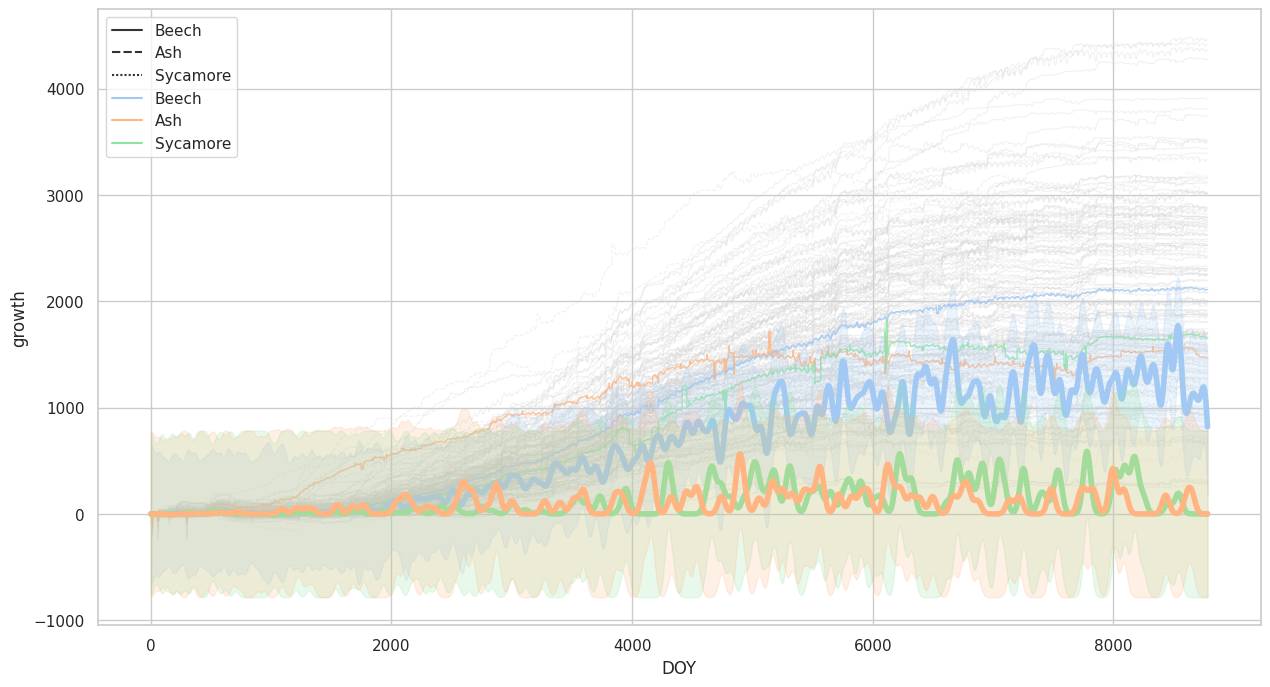

In [11]:
fig = plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid", palette="pastel")

# All lines
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    style="species",
    units="dendroNr",
    lw=0.8,
    estimator=None,
    c="lightgray",
    alpha=0.3,
)

# Plot means
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    hue="species",
    #estimator=None, errorbar=('ci', 99),
    errorbar=None,
    lw=1,
    zorder=2,
    alpha=0.8,
)

X = np.array(range(max(dendro.DOY))).reshape(-1, 1)

# Plot GP
for i, tree_model in enumerate(tree_models):
    mean_prediction, std_prediction = tree_model.predict(X, return_std=True)
    sns.lineplot(
        x=X.ravel(),
        y=mean_prediction.ravel(),
        lw=4,
        zorder=3,
        color=sns.color_palette()[i if i == 0 else [2, 1][i - 1]],
    )
    std_prediction *= 2000 #?
    plt.fill_between(
        X.ravel(),
        (mean_prediction - 1.96 * std_prediction).ravel(),
        (mean_prediction + 1.96 * std_prediction).ravel(),
        alpha=.2,
        zorder=3,
        color=sns.color_palette()[i if i == 0 else [2, 1][i - 1]],
    )

plt.show()